In [1]:
import os
import dascore as dc
from datetime import datetime
from typing import List
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

from utils import slice_das_segment

# Demo: slice_das_segment Function

This notebook demonstrates the usage of the `slice_das_segment` function from `utils.py`. This function extracts DAS (Distributed Acoustic Sensing) data segments within a specified time range by automatically finding and concatenating the appropriate files.

## Function Overview

**Function Signature:**
```python
slice_das_segment(start_time, end_time, source_dir)
```

**Parameters:**
- `start_time` (str): Start time in format "YYYYMMDDTHHMMSS" 
- `end_time` (str): End time in format "YYYYMMDDTHHMMSS"
- `source_dir` (str): Directory containing DAS HDF5 files

**Returns:**
- `dascore.Patch`: A DAS data segment containing recordings within the specified time range

**Key Features:**
- Automatically finds files that overlap with the time range
- Concatenates multiple files if the time range spans across files
- Handles temporal slicing to extract exact time windows
- Uses binary search for efficient file selection

## Tips and Best Practices

### **Usage Tips:**

1. **Time Format**: Always use the format "YYYYMMDDTHHMMSS" for start_time and end_time
2. **File Naming**: Ensure your DAS files follow the naming convention: `16B_StrainRate_YYYYMMDDTHHMMSS+0000_NNNNN.h5`
3. **Directory Structure**: Organize files in a single directory for optimal performance

### **Important Considerations:**

1. **Memory Usage**: Large time ranges will load more data into memory
2. **File Boundaries**: The function handles file concatenation automatically
3. **Time Zones**: Make sure your time stamps are in the same timezone as the file naming convention
4. **Error Handling**: Always wrap function calls in try-except blocks for robust code

### **Related Functions:**

- `timestamp2datetime()`: Convert string timestamps to datetime objects
- `timestampFromFilename()`: Extract timestamps from DAS filenames
- `binary_search_first_extreme()`: Efficiently find files in time ranges

# Example 1: Single File Time Range
This example demonstrates how a window of <12s is selected from a directory of DAS files. The function selects the appropriate file based on its name, and then cuts the signal to include only the samples from the given range (start_time, end_time).

In [ ]:
# Example 1: Basic Usage
# Define the source directory containing DAS files
source_dir = "/Users/danilodordevic/Desktop/Code/FORGE_bigstar/validation_data_traget"

# Define time range for extraction
# Format: "YYYYMMDDTHHMMSS"
start_time = "20240407T000040"  # April 7, 2024, 00:00:40
end_time = "20240407T000042"    # April 7, 2024, 00:00:42

print(f"Extracting DAS data from {start_time} to {end_time}")
print(f"Source directory: {source_dir}")

Extracting DAS data from 20240407T000040 to 20240407T000042
Source directory: /Users/danilodordevic/Desktop/Code/FORGE_bigstar/validation_data_traget


In [ ]:
# Execute the slice_das_segment function
try:
    # Extract the DAS segment
    das_patch = slice_das_segment(start_time, end_time, source_dir)
    das_patch = das_patch.transpose('distance', 'time')
    
    print("Successfully extracted DAS segment!")
    print(f"Patch shape: {das_patch.shape}")
    print(f"Time range: {das_patch.coords.get_array('time').min()} to {das_patch.coords.get_array('time').max()}")
    print(f"Number of channels: {len(das_patch.coords.get_array('distance'))}")
    print(f"Sampling rate: {1/(das_patch.attrs.coords['time'].step / np.timedelta64(1, 's'))} Hz")
    
except FileNotFoundError as e:
    print(f"ERROR: Source directory not found - {e}")
    print("Please update the source_dir path to point to your DAS data directory")
    
except Exception as e:
    print(f"ERROR extracting DAS segment: {e}")
    print("This might occur if no files exist in the specified time range.")

Successfully extracted DAS segment!
Patch shape: (1496, 10000)
Time range: 2024-04-07T00:00:40.000083900 to 2024-04-07T00:00:41.999883900
Number of channels: 1496
Sampling rate: 5000.0 Hz


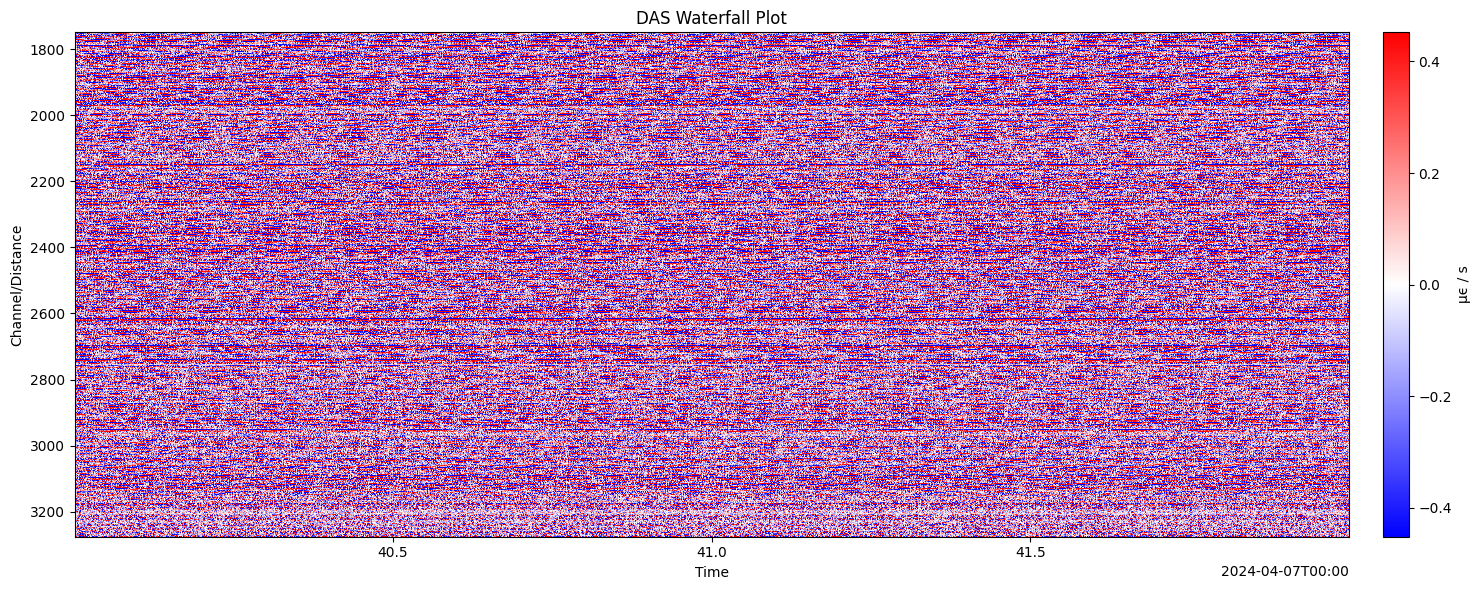

Plotted DAS data with shape: (1496, 10000)


In [4]:
# Check if we have a valid DAS patch to visualize
if 'das_patch' in locals() and das_patch is not None:
    try:
        # Create a single plot for waterfall
        fig, ax1 = plt.subplots(1, 1, figsize=(15, 6))
        
        # Plot: Waterfall plot using dascore
        das_patch.viz.waterfall(ax=ax1, scale=0.001)
        ax1.set_title("DAS Waterfall Plot")
        ax1.set_xlabel("Time")
        ax1.set_ylabel("Channel/Distance")
        
        plt.tight_layout()
        plt.show()
        
        print(f"Plotted DAS data with shape: {das_patch.data.shape}")
        
    except Exception as e:
        print(f"ERROR creating visualization: {e}")
else:
    print("ERROR: No DAS patch available for visualization. Please run the extraction cell first.")

## Example 2: Cross-File Time Range

This example demonstrates how `slice_das_segment` handles time ranges that span across multiple files. The function automatically identifies all relevant files, concatenates them, and cuts only the relevant segment.

In [ ]:
# Example 2: Extract data spanning multiple files
# This demonstrates how the function handles concatenation

# Define a longer time range that likely spans multiple files
start_time_long = "20240407T000040"
end_time_long = "20240407T000140"    # 1-minute window

print(f"Extracting longer DAS segment from {start_time_long} to {end_time_long}")
print("This time range likely spans multiple HDF5 files...")

try:
    # Extract the longer DAS segment
    das_patch_long = slice_das_segment(start_time_long, end_time_long, source_dir)
    das_patch_long = das_patch_long.transpose('distance', 'time')
    
    print("Successfully extracted multi-file DAS segment!")
    print(f"Patch shape: {das_patch_long.shape}")
    print(f"Time range: {das_patch_long.coords.get_array('time').min()} to {das_patch.coords.get_array('time').max()}")
    print(f"Number of channels: {len(das_patch_long.coords.get_array('distance'))}")
    print(f"Sampling rate: {1/(das_patch_long.attrs.coords['time'].step / np.timedelta64(1, 's'))} Hz")

    # Calculate approximate number of files used
    typical_file_duration = 12  # seconds (approximate)
    total_duration = (das_patch_long.coords['time'].max() - das_patch_long.coords['time'].min())/1e9
    estimated_files = int(total_duration / typical_file_duration) + 1
    print(f"Files concatenated: ~{estimated_files}")
    
except Exception as e:
    print(f"ERROR: {e}")
    print("This might occur if the source directory path is incorrect or files are missing")

Extracting longer DAS segment from 20240407T000040 to 20240407T000140
This time range likely spans multiple HDF5 files...
Successfully extracted multi-file DAS segment!
Patch shape: (1496, 300000)
Time range: 2024-04-07T00:00:40.000083900 to 2024-04-07T00:00:41.999883900
Number of channels: 1496
Sampling rate: 5000.0 Hz
Files concatenated: ~5


/var/folders/fr/hwzfn17j6rs1hf0zcx75pm3r0000gn/T/ipykernel_17580/3573343417.py:24: UserWarning: Currently coords[coord_name] returns a numpy array, but in a future dascore version it will return a BaseCoord instance. Use patch.coords.get_array(coord_name) instead.
  total_duration = (das_patch_long.coords['time'].max() - das_patch_long.coords['time'].min())/1e9


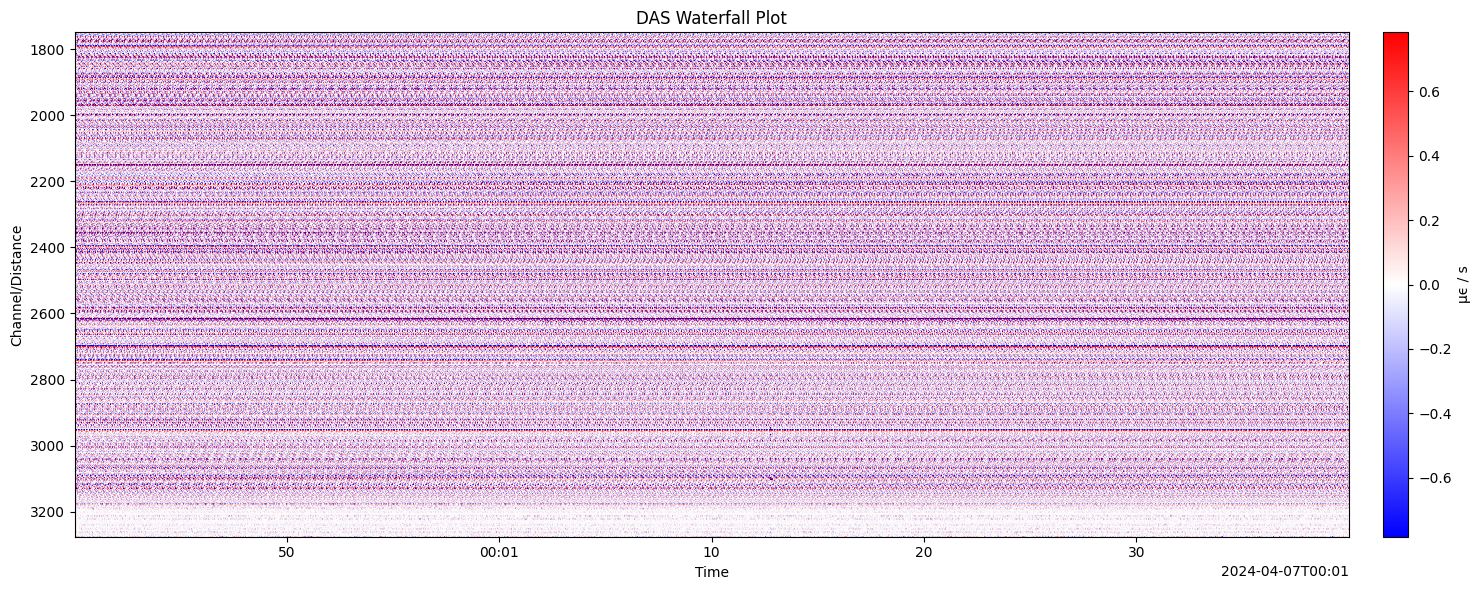

Plotted DAS data with shape: (1496, 300000)


In [6]:
# Check if we have a valid DAS patch to visualize
if 'das_patch_long' in locals() and das_patch_long is not None:
    try:
        # Create a single plot for waterfall
        fig, ax1 = plt.subplots(1, 1, figsize=(15, 6))
        
        # Plot: Waterfall plot using dascore
        das_patch_long.viz.waterfall(ax=ax1, scale=0.001)
        ax1.set_title("DAS Waterfall Plot")
        ax1.set_xlabel("Time")
        ax1.set_ylabel("Channel/Distance")
        
        plt.tight_layout()
        plt.show()
        
        print(f"Plotted DAS data with shape: {das_patch_long.data.shape}")
        
    except Exception as e:
        print(f"ERROR creating visualization: {e}")
else:
    print("ERROR: No DAS patch available for visualization. Please run the extraction cell first.")

## Example 3: Practical Usage with File Discovery

This example shows how to discover available files and choose appropriate time ranges, and their format.

In [7]:
# Example 3: Discover available files and time ranges
from utils import timestamp2datetime, timestampFromFilename

# For demo purposes, use a local directory that might exist
# Update this path to match your local setup
demo_source_dir = "/Users/danilodordevic/Desktop/Code/FORGE_bigstar/validation_data_traget"  # Fallback to current directory

# Function to discover available DAS files
def discover_das_files(directory):
    """Discover and analyze available DAS files in a directory."""
    try:
        files = [f for f in os.listdir(directory) if f.endswith('.h5') and f.startswith('16B')]
        if not files:
            print(f"ERROR: No DAS files found in {directory}")
            return []
        
        # Sort files by timestamp
        files_with_time = []
        for f in files:
            try:
                timestamp = timestampFromFilename(f)
                dt = timestamp2datetime(timestamp)
                files_with_time.append((f, dt, timestamp))
            except:
                continue
        
        files_with_time.sort(key=lambda x: x[1])
        return files_with_time
    
    except FileNotFoundError:
        print(f"ERROR: Directory not found: {directory}")
        return []

# Discover files
print(f"Discovering DAS files in: {demo_source_dir}")
available_files = discover_das_files(demo_source_dir)

if available_files:
    print(f"SUCCESS: Found {len(available_files)} DAS files")
    print("First 5 files:")
    for i, (filename, dt, timestamp) in enumerate(available_files[:5]):
        print(f"  {i+1}. {filename}")
        print(f"     Time: {dt} (timestamp: {timestamp})")
    
    print(f"\nTime range available:")
    print(f"  Start: {available_files[0][1]} ({available_files[0][2]})")
    print(f"  End:   {available_files[-1][1]} ({available_files[-1][2]})")
else:
    print("No files available for demonstration.")
    print("To run this demo with real data:")
    print("1. Update 'demo_source_dir' to point to your DAS data directory")
    print("2. Ensure the directory contains files matching pattern: 16B_StrainRate_*.h5")

Discovering DAS files in: /Users/danilodordevic/Desktop/Code/FORGE_bigstar/validation_data_traget
SUCCESS: Found 30 DAS files
First 5 files:
  1. 16B_StrainRate_20240407T000004+0000_32366.h5
     Time: 2024-04-07 00:00:04 (timestamp: 20240407T000004)
  2. 16B_StrainRate_20240407T000016+0000_32367.h5
     Time: 2024-04-07 00:00:16 (timestamp: 20240407T000016)
  3. 16B_StrainRate_20240407T000028+0000_32368.h5
     Time: 2024-04-07 00:00:28 (timestamp: 20240407T000028)
  4. 16B_StrainRate_20240407T000040+0000_32369.h5
     Time: 2024-04-07 00:00:40 (timestamp: 20240407T000040)
  5. 16B_StrainRate_20240407T000052+0000_32370.h5
     Time: 2024-04-07 00:00:52 (timestamp: 20240407T000052)

Time range available:
  Start: 2024-04-07 00:00:04 (20240407T000004)
  End:   2024-04-07 07:21:40 (20240407T072140)
